In [1]:
import glob, os
import pandas as pd
import torch
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

torch.manual_seed(1)
np.random.seed(1)

In [2]:
''' Task 4A
Gait-cycle extractor uses method from Section 3.2. "Extraction of Walking Cycles" of the paper 
"IDNet: Smartphone-based Gait Recognition with Convolutional Neural Networks" [https://arxiv.org/abs/1606.03238]
'''

' Task 4A\nGait-cycle extractor uses method from Section 3.2. "Extraction of Walking Cycles" of the paper \n"IDNet: Smartphone-based Gait Recognition with Convolutional Neural Networks" [https://arxiv.org/abs/1606.03238]\n'

In [3]:
def corr_dist(u, v):
    '''equation 2 from arxiv:1606.03238'''
    u_sub = u - u.mean()
    v_sub = v - v.mean()
    c = 1 - (torch.dot(u_sub, v_sub)/(torch.norm(u_sub)*torch.norm(v_sub)))
    return c

def local_mins_below_threshold(p, t):
	'''
	p <-- phi
	t <-- threshold
	'''

	local_min_bool = False
	local_mins = []
	local_min_region = []
	for pdx, _p in enumerate(p):
		#print(pdx, _p)
		if not local_min_bool:
			if _p < t:
				local_min_bool = True
				local_min_region.append(pdx)
		else:
			if _p >= t:
				local_min_bool = False
				local_min_region.append(pdx)
				local_mins.append(local_min_region[0] + np.argmin(p[local_min_region[0]:local_min_region[1]]))
				local_min_region = []

	return local_mins

def template_exactor(a_mag):
	T = a_mag[T_starting_point:T_starting_point+T_init_range]

	phi = torch.FloatTensor(len(a_mag)  + 1 - T_init_range).zero_()
	for _ in range(num_epochs):
		for i in range(len(a_mag) + 1 - T_init_range):
			phi[i] = corr_dist(T, a_mag[i:i+T_init_range])
		mins = local_mins_below_threshold(phi.numpy(), threshold)
		Tp = a_mag[mins[1]:mins[1]+T_init_range]
		T = lr*T + (1 - lr)*Tp

	return T, phi

In [5]:
df_data1 = pd.read_csv('data/walkData1.csv')
df_data2 = pd.read_csv('data/walkData2.csv')
print(df_data1.shape)
print(df_data2.shape)

(918, 9)
(857, 9)


In [6]:
df_data1.head(10)

,timestep,a_x,a_y,a_z,a_mag,g_x,g_y,g_z,g_mag
0,0,-3802,574,7110,8083.116973,86,9,-15,87.761039
1,1,-3812,568,7176,8145.486112,117,34,-3,121.876987
2,2,-3892,488,7150,8155.262595,177,63,15,188.475463
3,3,-3942,544,7376,8380.971065,261,134,67,300.941855
4,4,-4278,546,7300,8478.761702,378,239,104,459.152480
5,5,-4252,418,7020,8217.945485,441,207,127,503.447117
6,6,-3626,728,7076,7984.211671,455,92,163,491.993902
7,7,-3718,894,7242,8189.586314,388,91,137,421.419031
8,8,-4024,926,7148,8254.935251,321,136,129,371.723015
9,9,-3976,988,7288,8360.601892,271,65,95,294.433354


In [7]:
df_data2.head(10)

,timestep,a_x,a_y,a_z,a_mag,g_x,g_y,g_z,g_mag
0,0,-4066,566,6954,8075.322161,53,394,-98,409.449631
1,1,-4128,586,6950,8104.707274,42,410,-88,421.435642
2,2,-3984,562,6918,8002.925965,45,415,-91,427.236468
3,3,-4006,414,7164,8218.413959,100,521,-93,538.600037
4,4,-3988,206,7074,8123.303269,172,584,-160,629.475973
5,5,-3644,748,6814,7763.300587,146,753,-49,768.587015
6,6,-4334,314,7356,8543.587537,217,954,-24,978.662863
7,7,-4348,730,6930,8213.580462,311,1024,-52,1071.448086
8,8,-4182,796,7390,8528.472313,341,1179,-172,1239.316747
9,9,-4142,1064,6918,8133.079614,341,1285,-447,1402.610067


In [8]:
a_max_timestep = 740 #There's some noise at the end so stop early
a_mag1 = torch.from_numpy(np.asarray(df_data1['a_mag'].tolist()[0:a_max_timestep]))
a_mag2 = torch.from_numpy(np.asarray(df_data2['a_mag'].tolist()[0:a_max_timestep]))

In [9]:
T_init_range = 130 #Ns from IDNet paper #size of template
T_starting_point = 100 #left starting point of template
threshold = .4 #threshold which local minima regions must be below

lr = .9 #learning rate of gait-cycle template extractor
num_epochs = 100 #for gait-cycle template extractor

#T (1 & 2) is gait-cycle template extracted from each walk; this is the ML part of 4A
T1, _ = template_exactor(a_mag1)
T2, _ = template_exactor(a_mag2)

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.ion()

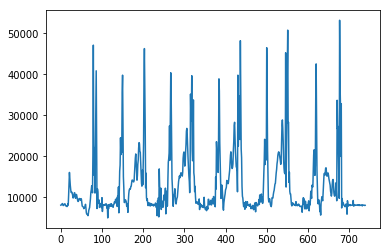

In [15]:
#raw gait accel magnitude data1
plt.figure()
plt.plot(a_mag1.numpy())

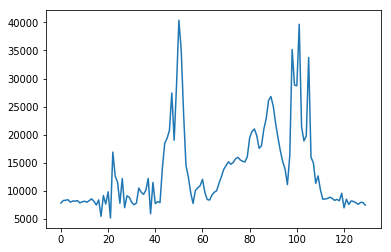

In [16]:
#gait-cycle template extracted from walk1
plt.figure()
plt.plot(T1.numpy())

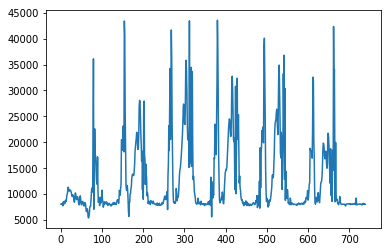

In [17]:
#raw gait accel magnitude data2
plt.figure()
plt.plot(a_mag2.numpy())

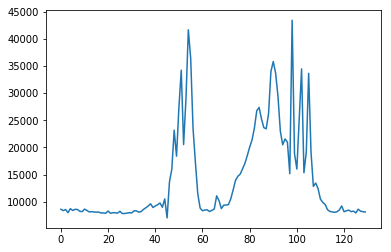

In [18]:
plt.figure()
plt.plot(T2.numpy())

In [19]:
np.save('T1.npy',T1.numpy())
np.save('T2.npy',T2.numpy())

In [22]:
''' Task 4B
Pocket-transfer performs Neural Style Transfer [https://arxiv.org/abs/1508.06576] using the features from an IDNet [ArXiv:1606.03238] pretrained on full IDNet dataset: http://signet.dei.unipd.it/human-sensing/
IDNet implementation is base on: https://github.com/vinayprabhu/Gait_FGSM/blob/master/IDNet_Adversarial_CVPR.ipynb
Neural Style Transfer implementation is based on: http://pytorch.org/tutorials/advanced/neural_style_tutorial.html
'''

' Task 4B\nPocket-transfer performs Neural Style Transfer [https://arxiv.org/abs/1508.06576] using the features from an IDNet [ArXiv:1606.03238] pretrained on full IDNet dataset: http://signet.dei.unipd.it/human-sensing/\nIDNet implementation is base on: https://github.com/vinayprabhu/Gait_FGSM/blob/master/IDNet_Adversarial_CVPR.ipynb\nNeural Style Transfer implementation is based on: http://pytorch.org/tutorials/advanced/neural_style_tutorial.html\n'

In [29]:
df_data = pd.read_csv('IDNet_dataset.csv')

Ns = 130 #size of each of contiguous chunk
N_samples=df_data.shape[0]//Ns
rounded_data_idx = N_samples*Ns

col_sensors=[u'a_mag']
X_train_test=df_data.loc[:,col_sensors][:rounded_data_idx].as_matrix().T.reshape(N_samples,1,1,Ns)
y_train_test_vec=df_data.loc[:,'user_id'][:rounded_data_idx].values[0::Ns]

In [30]:
from random import shuffle as shuffle_array
from sklearn.model_selection import StratifiedKFold
# For an 80-20 split
skf = StratifiedKFold(n_splits=5,shuffle=True)
ind_split=skf.split(np.zeros(N_samples), y_train_test_vec)
train_indices=ind_split.__next__()[0]
test_indices=ind_split.__next__()[1]
shuffle_array(train_indices)
shuffle_array(test_indices)

y_train=y_train_test_vec[train_indices]
y_test=y_train_test_vec[test_indices]

X_train=X_train_test[train_indices,:,:,:]
X_test=X_train_test[test_indices,:,:,:]

nb_classes=50
batch_size = 128
chunks_train = X_train.shape[0]//batch_size
max_size_train = batch_size*chunks_train

chunks_test = X_test.shape[0]//batch_size
max_size_test = batch_size*chunks_test

Y_train = np.split(np.array(y_train-1, dtype=np.float64)[:max_size_train], chunks_train)
Y_test = np.split(np.array(y_test-1, dtype=np.float64)[:max_size_test], chunks_test)

X_train = np.split(np.asarray(X_train, dtype=np.float64)[:max_size_train], chunks_train)
X_test = np.split(np.asarray(X_test, dtype=np.float64)[:max_size_test], chunks_test)

In [31]:
class IDNet(torch.nn.Module):
    def __init__(self, ob_space, action_space):
        super(IDNet, self).__init__()

        self.f = nn.Sequential(
            nn.Conv2d(ob_space[1], 20, kernel_size=(1,10)),
            nn.ReLU(),
            nn.Conv2d(20, 40, kernel_size = (1,10)),
            nn.Tanh(),
            nn.MaxPool2d(1, 3),
            )
        self.linear1 = nn.Linear(1520, 40)
        self.linear2 = nn.Linear(40, action_space)

        #self.apply(weights_init)
        self.train()

    def forward(self, inputs):
        x = self.f(inputs)
        x = x.view(x.size(0), -1)
        x = F.tanh(self.linear1(x))
        #maybe dropout .5 here
        x = F.log_softmax(self.linear2(x))
        return x

In [32]:
'''
This trains the IDNet whose features will later be used 
to perform Neural Style Transfer between the different gait templates.
'''
model = IDNet(X_train[0].shape, 50)
#model.load_state_dict(torch.load('./weights/'+"model"+'.pth'))
if torch.cuda.is_available():
    model.cuda()

net_lr = .001
optimizer = optim.Adam(model.parameters(), lr=net_lr)

log_interval = 70

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(zip(X_train, Y_train)):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(torch.from_numpy(data).float()), Variable(torch.from_numpy(target).long())
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
    print('Train Epoch: {} \tLoss: {:.6f}'.format(
        epoch, loss.data[0]))

def test():
    torch.save(model.state_dict(), './weights/'+"model"+'.pth')
    model.eval()
    test_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(zip(X_test, Y_test)):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(torch.from_numpy(data).float(), volatile=True), Variable(torch.from_numpy(target).long())
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(Y_test)*128
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, max_size_test,
        100. * correct / max_size_test))

epochs = 100
for epoch in range(1, epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 	Loss: 3.293917

Test set: Average loss: 3.4115, Accuracy: 331/3456 (10%)

Train Epoch: 2 	Loss: 2.857081

Test set: Average loss: 2.9522, Accuracy: 806/3456 (23%)

Train Epoch: 3 	Loss: 2.573154

Test set: Average loss: 2.6181, Accuracy: 1050/3456 (30%)

Train Epoch: 4 	Loss: 2.244673

Test set: Average loss: 2.3560, Accuracy: 1286/3456 (37%)

Train Epoch: 5 	Loss: 2.110680

Test set: Average loss: 2.1288, Accuracy: 1513/3456 (44%)

Train Epoch: 6 	Loss: 1.903517

Test set: Average loss: 1.9858, Accuracy: 1658/3456 (48%)

Train Epoch: 7 	Loss: 1.741656

Test set: Average loss: 1.8153, Accuracy: 1898/3456 (55%)

Train Epoch: 8 	Loss: 1.599007

Test set: Average loss: 1.6375, Accuracy: 2074/3456 (60%)

Train Epoch: 9 	Loss: 1.408538

Test set: Average loss: 1.5483, Accuracy: 2110/3456 (61%)

Train Epoch: 10 	Loss: 1.263407

Test set: Average loss: 1.4008, Accuracy: 2256/3456 (65%)

Train Epoch: 11 	Loss: 1.167879

Test set: Average loss: 1.2736, Accuracy: 2382/3456 (69%)


In [33]:
##############################
'''
based on http://pytorch.org/tutorials/advanced/neural_style_tutorial.html
Neural Style Transfer uses features from pretrained IDNet 
to transfer style between the different gait templates
'''

'\nbased on http://pytorch.org/tutorials/advanced/neural_style_tutorial.html\nNeural Style Transfer uses features from pretrained IDNet \nto transfer style between the different gait templates\n'

In [34]:

use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

# desired size of the output image
imsize = 512 if use_cuda else 128  # use small size if no gpu

def template_loader(image_name):
    image = np.load(image_name)
    image = Variable(torch.from_numpy(image))
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0).unsqueeze(0).unsqueeze(0)
    return image


def imshow(tensor, title=None):
    plt.plot(tensor.squeeze().numpy())
    if title is not None:
        plt.title(title)
    plt.show()
    plt.pause(0.001) # pause a bit so that plots are updated


class ContentLoss(nn.Module):
    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        self.target = target.detach() * weight
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.criterion(input * self.weight, self.target)
        self.output = input
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

class GramMatrix(nn.Module):
    def forward(self, input):
        a, b, c, d = input.size()  # a=batch size(=1)
        # b=number of feature maps
        # (c,d)=dimensions of a f. map (N=c*d)

        features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(a * b * c * d)

class StyleLoss(nn.Module):
    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G, self.target)
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

In [35]:
#get features (f) from trained IDNet
cnn = model.f

# move it to the GPU if possible:
if use_cuda:
    cnn = cnn.cuda()

# desired depth layers to compute style/content losses :
content_layers_default = ['conv_2']
style_layers_default = ['conv_1', 'conv_2']

In [37]:
'''Main portion of Neural Style Transfer Algorithm'''

def get_style_model_and_losses(cnn, style_img, content_img,
                               style_weight=1000, content_weight=1,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    model = nn.Sequential()  # the new Sequential module network
    gram = GramMatrix()  # we need a gram module in order to compute style targets

    # move these modules to the GPU if possible:
    if use_cuda:
        model = model.cuda()
        gram = gram.cuda()

    i = 1
    for layer in list(cnn):
        if isinstance(layer, nn.Conv2d):
            name = "conv_" + str(i)
            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                print(style_img)
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

        if isinstance(layer, nn.ReLU):
            name = "relu_" + str(i)
            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

            i += 1

        if isinstance(layer, nn.Tanh):
            name = "relu_" + str(i)
            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

            i += 1

        if isinstance(layer, nn.MaxPool2d):
            name = "pool_" + str(i)
            model.add_module(name, layer)  # ***

    return model, style_losses, content_losses

def get_input_param_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    input_param = nn.Parameter(input_img.data)
    optimizer = optim.LBFGS([input_param])
    return input_param, optimizer

def run_style_transfer(cnn, content_img, style_img, input_img, num_steps=300,
                       style_weight=1000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        style_img, content_img, style_weight, content_weight)
    input_param, optimizer = get_input_param_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_param.data.clamp_(min=0)

            optimizer.zero_grad()
            model(input_param)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.backward()
            for cl in content_losses:
                content_score += cl.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.data[0], content_score.data[0]))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_param.data.clamp_(min=0)

    return input_param.data

In [38]:
'''Code below runs and visualizes the transfer of style of T1 to content of T2 and vice-versa.'''

'Code below runs and visualizes the transfer of style of T1 to content of T2 and vice-versa.'

In [40]:

T1 = template_loader('T1.npy').type(dtype)
T2 = template_loader('T2.npy').type(dtype)

assert T1.size() == T2.size(), \
    "we need to import style and content templates of the same size"

plt.ion()

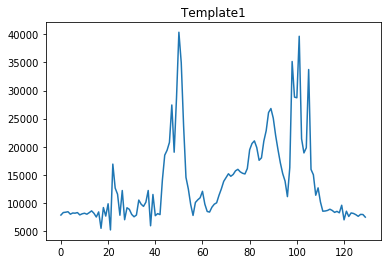

In [41]:
plt.figure()
imshow(T1.data, title='Template1')

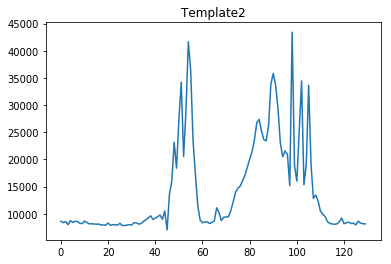

In [42]:
plt.figure()
imshow(T2.data, title='Template2')

In [47]:
'''Transfers Style from Template 1 to Content from Template 2'''
style_img = T1
content_img = T2
input_img = content_img.clone()
output = run_style_transfer(cnn, content_img, style_img, input_img)

Building the style transfer model..
Variable containing:
( 0 , 0 ,.,.) = 

Columns 0 to 5 
    7858.3784   8305.9609   8363.1758   8448.3506   8011.4209   8223.7930

Columns 6 to 11 
    8190.1270   8299.6191   7885.4058   8080.9043   8182.5278   8008.4570

Columns 12 to 17 
    8287.4434   8603.3857   8169.6606   7507.8213   8416.8936   5501.3237

Columns 18 to 23 
    9191.0879   7680.7617   9862.9688   5216.4360  16916.4668  12655.9570

Columns 24 to 29 
   11570.9590   7828.0659  12220.4102   7028.9604   9156.4697   8874.8555

Columns 30 to 35 
    7971.4648   7552.4570   7863.9248  10521.8311   9790.6504   9400.4287

Columns 36 to 41 
   10134.7549  12224.4297   5953.7686  11516.2803   7749.6924   8112.0986

Columns 42 to 47 
    7939.2822  14070.2637  18507.6758  19379.6191  20784.4961  27426.6914

Columns 48 to 53 
   19032.8730  28773.8125  40358.5547  34931.0078  23673.5527  14561.4453

Columns 54 to 59 
   12498.3252   9732.1875   7792.2495  10096.2441  10565.2520  10932.1123

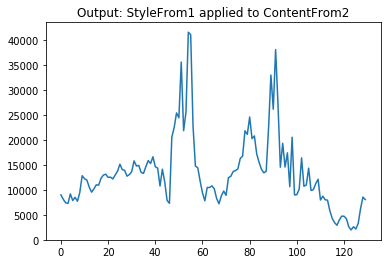

In [45]:
plt.figure()
imshow(output, title='Output: StyleFrom1 applied to ContentFrom2')

In [48]:
'''Transfers Style from Template 2 to Content from Template 1'''
style_img = T2
content_img = T1
input_img = content_img.clone()
output = run_style_transfer(cnn, content_img, style_img, input_img)

Building the style transfer model..
Variable containing:
( 0 , 0 ,.,.) = 

Columns 0 to 5 
    8620.9658   8370.6523   8567.3164   7993.8252   8731.5127   8400.2891

Columns 6 to 11 
    8611.8457   8578.7119   8258.1436   8177.8257   8652.8545   8410.1699

Columns 12 to 17 
    8132.9351   8175.6753   8114.8296   8090.2280   8103.2788   7936.7012

Columns 18 to 23 
    7947.9146   7876.4116   8302.2197   7872.4375   7996.0410   7981.5376

Columns 24 to 29 
    7902.0464   8245.0449   7838.1133   7842.6606   7913.2822   7988.7290

Columns 30 to 35 
    7941.9116   8340.1641   8317.4141   8094.9932   8197.4746   8603.1221

Columns 36 to 41 
    8895.7822   9220.9824   9627.1660   8948.2520   9228.4160   9458.1904

Columns 42 to 47 
    9774.1719   8987.5488  10523.2969   7028.2334  13633.2227  15993.0146

Columns 48 to 53 
   23174.7324  18396.5469  27297.7031  34223.3633  20529.3848  28987.6738

Columns 54 to 59 
   41654.9180  36423.0898  23483.9824  17237.0664  11493.3643   8848.7363

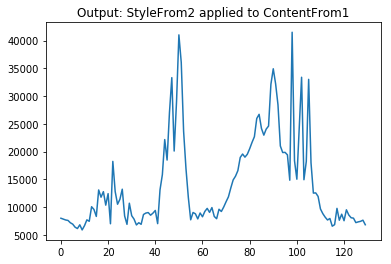

In [49]:
plt.figure()
imshow(output, title='Output: StyleFrom2 applied to ContentFrom1')

In [50]:
plt.ioff()
plt.show()